In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from depth_evaluation_utils import *
from pose_evaluation_utils import *
from glob import glob
import os

# Functions

In [2]:
def plotPoses(pred_dir, gt_dir):

    pred_files = sorted(glob(pred_dir + '/*.txt'))
    gt_files = sorted(glob(gt_dir + '/*.txt'))
    xz_pred, xz_gt = [],[]
    
    for i in range(len(gt_files)):
        gtruth_file = gt_dir + os.path.basename(pred_files[i])
        pred_file = pred_files[i]

        gtruth_list = read_file_list(gtruth_file)
        pred_list = read_file_list(pred_file)
        matches = associate(gtruth_list, pred_list, 0, 0.01)
        if len(matches) < 2:
            print('False')

        gtruth_xyz = np.array([[float(value) for value in gtruth_list[a][0:3]] for a,b in matches])
        pred_xyz = np.array([[float(value) for value in pred_list[b][0:3]] for a,b in matches])

        # Make sure that the first matched frames align (no need for rotational alignment as
        # all the predicted/ground-truth snippets have been converted to use the same coordinate
        # system with the first frame of the snippet being the origin).
        offset = gtruth_xyz[0] - pred_xyz[0]
        pred_xyz += offset[None,:]

        # Optimize the scaling factor
        scale = np.sum(gtruth_xyz * pred_xyz)/np.sum(pred_xyz ** 2)
        pred_xyz = pred_xyz * scale
            
        n=1
        if i==0:
            prevx,prevz = pred_xyz[n][0], pred_xyz[n][2]
            gtx, gtz = gtruth_xyz[n][0], gtruth_xyz[n][2]
        else:
            prevx, prevz = prevx + pred_xyz[n][0], prevz+ pred_xyz[n][2]
            gtx, gtz = gtx + gtruth_xyz[n][0], gtz+ gtruth_xyz[n][2]

        xz_pred.append([prevx, -prevz])
        xz_gt.append([gtx, -gtz])
    xz_gt= np.array(xz_gt)
    xz_pred= np.array(xz_pred)
    return xz_pred, xz_gt

def normalize_depth_for_display(depth, pc=95, crop_percent=0, normalizer=None, cmap='gray'):
    # convert to disparity
    depth = 1./(depth + 1e-6)
    if normalizer is not None:
        depth = depth/normalizer
    else:
        depth = depth/(np.percentile(depth, pc) + 1e-6)
    depth = np.clip(depth, 0, 1)
    depth = gray2rgb(depth, cmap=cmap)
    keep_H = int(depth.shape[0] * (1-crop_percent))
    depth = depth[:keep_H]
    depth = depth
    return depth

def gray2rgb(im, cmap='gray'):
    cmap = plt.get_cmap(cmap)
    rgba_img = cmap(im.astype(np.float32))
    rgb_img = np.delete(rgba_img, 3, 2)
    return rgb_img


# Pose

In [3]:
gt_dir = './pose_eval_data/pose_data/ground_truth/09/'
pred_dir = '../../sfmLearner_checkpoints/outputs/pose_SSIM_vgg12_slvlr/'

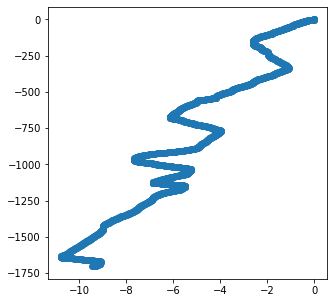

In [10]:
# vgg12
xz_pred, _ = plotPoses(pred_dir, gt_dir)
plt.figure(figsize= (5,5))
plt.scatter(xz_pred[:,0], xz_pred[:,1])

# Depth

In [36]:
ground_truths = np.load('../../sfmLearner_checkpoints/outputs/gtdepths.npy', allow_pickle=True)
# predictions = np.load('../../sfmLearner_checkpoints/outputs/depth_onlySSIM_fixedLR/model-161512.npy')
predictions = np.load('../../sfmLearner_checkpoints/outputs/depth_SSIM_vgg16_slvlr/model-198784.npy')
# sfmLearner_checkpoints/outputs/gtdepths.npy

In [37]:
def get_available_data(dataset_dir, test_files):
    
    def dircheck(dirs, folder):
        for directory in dirs:
            if folder==directory:
                return True
        return False

    dirs = next(os.walk(dataset_dir))[1] # get list of all child dirs
    available_test_files = []
    # for every test_file, check whether raw data is available
    counter = 0
    for i in range(len(test_files)): 
        folder = test_files[i][:10]
        if dircheck(dirs, folder):
            available_test_files.append(test_files[i])
        else:
            counter +=1
    print("No. of test files not available:", counter)
    return available_test_files

dataset_dir = '../../TrainingAndValData/Kitti_raw/'
with open('../data/kitti/test_files_eigen.txt', 'r') as f:
    test_files = f.readlines()
    test_files = get_available_data(dataset_dir, test_files)
    test_files = [dataset_dir + t[:-1] for t in test_files]


No. of test files not available: 150


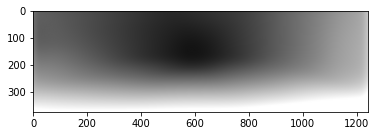

In [38]:
i= 500
min_depth = 0
max_depth = 80
gt_depth = ground_truths[i]
pred_depth = np.copy(cv2.resize(predictions[i], (ground_truths[i].shape[1], ground_truths[i].shape[0]), interpolation=cv2.INTER_LINEAR))

# im = cv2.imread(test_files[500])
# plt.figure(figsize=(10,5))
# plt.imshow(im)
# cv2.imwrite('../../image.png', im)

plt.imshow(normalize_depth_for_display(pred_depth))
plt.savefig('../../onlySSIM_fixedLR')
# plt.savefig('../../no_tweaks_vl')

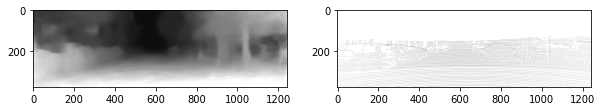

In [47]:
i= 500
min_depth = 0
max_depth = 80
gt_depth = ground_truths[i]
pred_depth = np.copy(cv2.resize(predictions[i], (ground_truths[i].shape[1], ground_truths[i].shape[0]), interpolation=cv2.INTER_LINEAR))

fig,plts = plt.subplots(1,2, figsize=(10,5))
plts[0].imshow(normalize_depth_for_display(pred_depth))
plts[1].imshow(normalize_depth_for_display(gt_depth))

In [57]:
mask = np.logical_and(gt_depth > min_depth, 
                        gt_depth < max_depth)
# crop used by Garg ECCV16 to reprocude Eigen NIPS14 results
# if used on gt_size 370x1224 produces a crop of [-218, -3, 44, 1180]
gt_height, gt_width = gt_depth.shape
crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                    0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

crop_mask = np.zeros(mask.shape)
crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1

mask = np.logical_and(mask, crop_mask)

# Scale matching
scalor = np.median(gt_depth[mask])/np.median(pred_depth[mask])
pred_depth[mask] *= scalor

pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth
# gt_depth, pred_depth = gt_depth[mask], pred_depth[mask]

In [58]:
pred_depth_out = np.logical_and(mask, pred_depth)
gt_depth_out = np.logical_and(mask, gt_depth)